# Setup

## Install Packages

In [2]:
# load those needed packages and libraries
import torch
#import optuna
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as ro

from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
#from sklearn.model_selection import train_test_split
#from nltk.translate.bleu_score import SmoothingFunction
from transformers import T5Tokenizer, T5ForConditionalGeneration
from rpy2.robjects import pandas2ri

c:\Users\Bryan Chan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Device 

In [ ]:
# set the device to cuda if available else cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Datasets

In [3]:
# define Data file directory
data_dir = r'C:\Users\Bryan Chan\Documents\Projects\thesis_data\\'

## UNGA

In [ ]:
# UN General Assembly
CB_UNGA = pd.read_csv(data_dir + r'UNGA\Speakers_by_session.csv')
CB_UNGA

,Year,Session,ISO Code,Country,Name of Person Speaking,Post,Unnamed: 6
0,2022,77,BRA,Brazil,Jair Bolsonaro,President,NaN
1,2022,77,SEN,Senegal,Macky Sail,President,NaN
2,2022,77,CHL,Chile,Gabriel Boric Font,President,NaN
3,2022,77,JOR,Jordan,Abdullah II ibn Al Hussein,King,NaN
4,2022,77,COL,Colombia,Gustavo Petro Urrego,President,NaN
...,...,...,...,...,...,...,...
10554,1946,1,USA,United States of America,Mr. Austin,NaN,NaN
10555,1946,1,IRN,Iran,Mr. Entezam,NaN,NaN
10556,1946,1,URY,Uruguay,Mr. Blanco,NaN,NaN
10557,1946,1,LUX,Luxembourg,Mr. Bech,NaN,NaN


## UNSC

In [4]:
r = ro.r 
r['load'](data_dir + r"UNSC\docs.RData")
r['load'](data_dir + r"UNSC\docs_meta.RData")

# Lists the objects currently in the R environment
loaded_objects = r['ls']()
print("Loaded objects:", loaded_objects)


Loaded objects: [1] "meta_meetings"           "meta_speeches"          
[3] "national_capacities"     "prst_speeches_filenames"
[5] "raw_docs"                "un_capacities"          



In [5]:
import pandas as pd
from rpy2.robjects import pandas2ri

# Access the objects by their actual names
meta_meetings = r['meta_meetings']
meta_speeches = r['meta_speeches']
national_capacities = r['national_capacities']
prst_speeches_filenames = r['prst_speeches_filenames']
raw_docs = r['raw_docs']
un_capacities = r['un_capacities']

print("meta_meetings type:", type(meta_meetings))
print("meta_speeches type:", type(meta_speeches))
print("national_capacities type:", type(national_capacities))
print("prst_speeches_filenames type:", type(prst_speeches_filenames))
print("raw_docs type:", type(raw_docs))
print("un_capacities type:", type(un_capacities))


meta_meetings type: <class 'rpy2.robjects.vectors.DataFrame'>
meta_speeches type: <class 'rpy2.robjects.vectors.DataFrame'>
national_capacities type: <class 'rpy2.robjects.vectors.StrVector'>
prst_speeches_filenames type: <class 'rpy2.robjects.vectors.StrVector'>
raw_docs type: <class 'rpy2.robjects.vectors.DataFrame'>
un_capacities type: <class 'rpy2.robjects.vectors.StrVector'>


In [6]:
# Activate the pandas conversion
pandas2ri.activate()

# Convert R objects to pandas DataFrames
df_UNSC_meta_meetings = pandas2ri.rpy2py(meta_meetings)
df_UNSC_meta_speeches = pandas2ri.rpy2py(meta_speeches)
#df_UNSC_national_capacities = pandas2ri.rpy2py(national_capacities)
#df_UNSC_prst_speeches_filenames = pandas2ri.rpy2py(prst_speeches_filenames)
df_UNSC_raw_docs = pandas2ri.rpy2py(raw_docs)
#df_UNSC_un_capacities = pandas2ri.rpy2py(un_capacities)

In [27]:
print(type(df_UNSC_meta_meetings))           # DataFrame
print(type(df_UNSC_meta_speeches))           # DataFrame
print(type(df_UNSC_national_capacities))
print(type(df_UNSC_prst_speeches_filenames))
print(type(df_UNSC_raw_docs))                # DataFrame
print(type(df_UNSC_un_capacities))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [9]:
df_UNSC_meta_meetings.to_csv('df_UNSC_meta_meetings.csv', index=False)
df_UNSC_meta_speeches.to_csv('df_UNSC_meta_speeches.csv', index=False)
df_UNSC_raw_docs.to_csv('df_UNSC_raw_docs.csv', index=False)

In [33]:
df_UNSC_meta_meetings.info()
df_UNSC_meta_speeches.info()
df_UNSC_raw_docs.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5748 entries, 1 to 5590
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   basename      5748 non-null   object 
 1   date          5748 non-null   object 
 2   num_speeches  5748 non-null   float64
 3   topic         5748 non-null   object 
 4   pressrelease  5748 non-null   object 
 5   outcome       5748 non-null   object 
 6   year          5748 non-null   float64
 7   month         5748 non-null   object 
 8   day           5748 non-null   object 
dtypes: float64(2), object(7)
memory usage: 578.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 82165 entries, 1 to 82165
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   speech           82165 non-null  float64
 1   country          82165 non-null  object 
 2   speaker          81631 non-null  object 
 3   participanttype  82165 non-null  

In [35]:
df_UNSC_meta_speeches.tail(2)

,speech,country,speaker,participanttype,role_in_un,spv,basename,topic,date,year,...,filename,types,tokens,sentences,topic2,subtopic,agenda_item1,agenda_item2,agenda_item3,decision
82164,19.0,Viet Nam,Pham Hai Anh,Mentioned,,2020_1324,UNSC_2020_SPV.2020_1324,Non-proliferation,22 December 2020,2020.0,...,UNSC_2020_SPV.2020_1324_spch019.txt,338.0,807.0,27.0,Items relating to non-proliferation,Non-proliferation of weapons of mass destruction,Thematic,Non-proliferation,Thematic,None
82165,20.0,Islamic Republic Of Iran,Majid Takht Ravanchi,Guest,,2020_1324,UNSC_2020_SPV.2020_1324,Non-proliferation,22 December 2020,2020.0,...,UNSC_2020_SPV.2020_1324_spch020.txt,725.0,2127.0,69.0,Items relating to non-proliferation,Non-proliferation of weapons of mass destruction,Thematic,Non-proliferation,Thematic,None


In [39]:
df_merged = pd.merge(df_UNSC_meta_speeches, df_UNSC_raw_docs[['doc_id', 'text']], 
left_on='filename', 
right_on='doc_id', 
how='left')

df_merged.drop(columns=['doc_id'], inplace=True)

df_merged['text'].isna().sum()

0

# EDA

In [ ]:
# Who spoke the most
speaker_counts = CB_UNGA['Country'].value_counts().head(150)

plt.figure(figsize = (20, 6))
plt.bar(speaker_counts.index, speaker_counts.values)
plt.xlabel("Country")
plt.ylabel("Count of Speakers")
plt.title("Number of Speakers by Country in UN General Assembly")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Speakers by Session and Year
pivot_table = pd.pivot_table(CB_UNGA, values='Name of Person Speaking', index=['Year', 'Session'], aggfunc='count')
pivot_table


,,Name of Person Speaking
Year,Session,
1946,1,39
1947,2,39
1948,3,39
1949,4,35
1950,5,44
...,...,...
2018,73,196
2019,74,195
2020,75,193


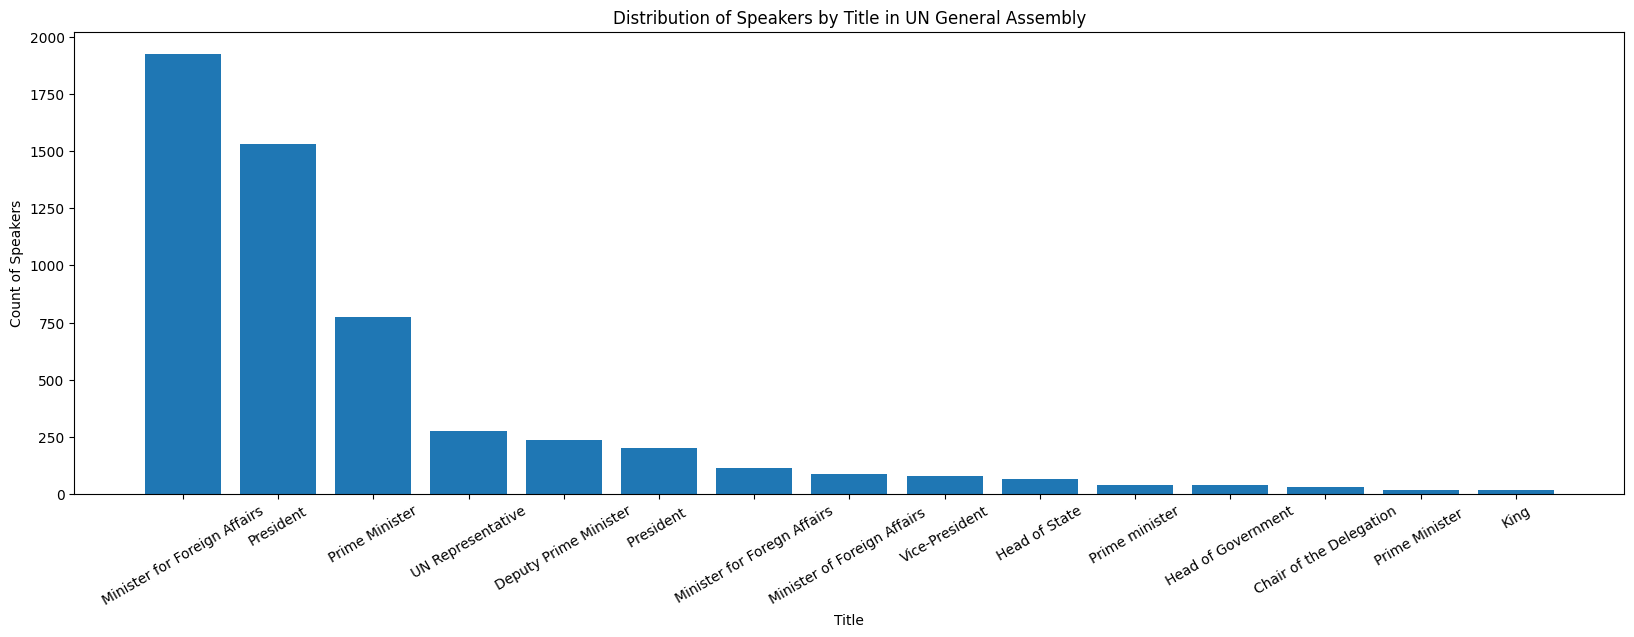

In [ ]:
#Distribution of Speakers by Title
speaker_titles = CB_UNGA['Post'].value_counts().head(15)
plt.figure(figsize = (20, 6))
plt.bar(speaker_titles.index, speaker_titles.values)
plt.xlabel("Title")
plt.ylabel("Count of Speakers")
plt.title("Distribution of Speakers by Title in UN General Assembly")

plt.xticks(rotation=30)
plt.show()

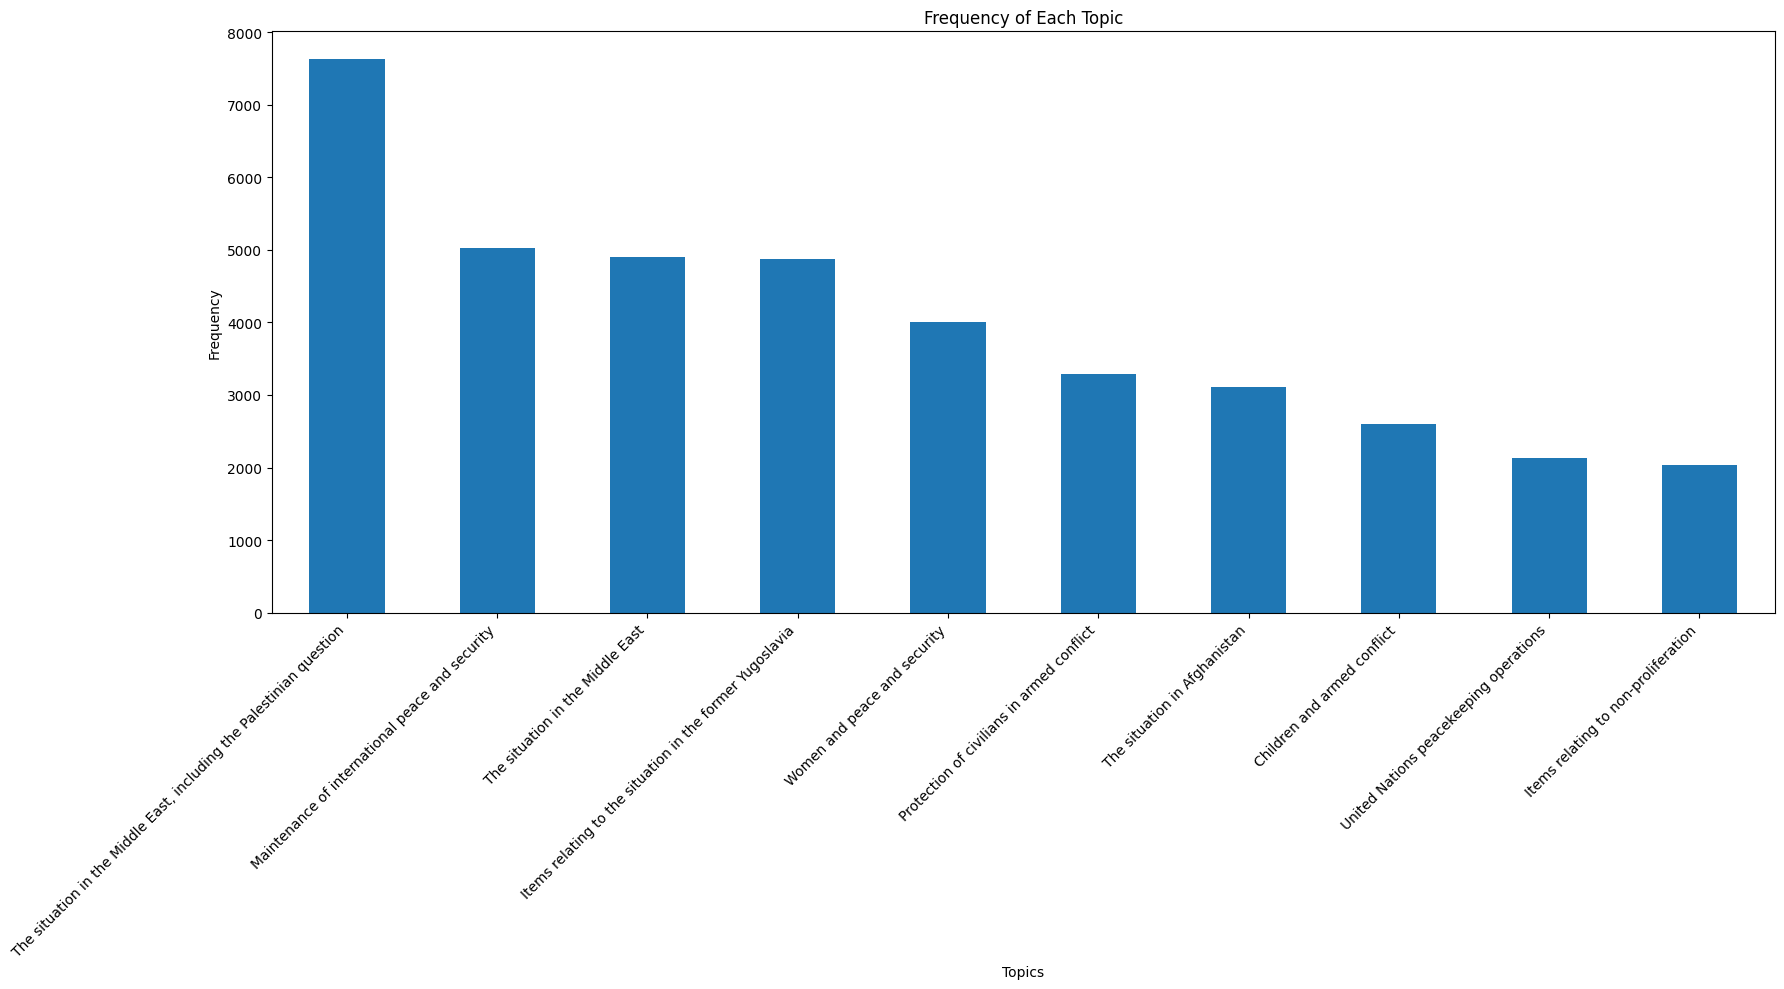

In [7]:
# Frequency of each unique value in the "topic2" column 

topic2_counts = df_UNSC_meta_speeches['topic2'].value_counts().head(10)
plt.figure(figsize=(18, 10))
topic2_counts.plot(kind='bar')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Frequency of Each Topic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
df_UNSC_meta_speeches.columns

Index(['speech', 'country', 'speaker', 'participanttype', 'role_in_un', 'spv',
       'basename', 'topic', 'date', 'year', 'month', 'day', 'filename',
       'types', 'tokens', 'sentences', 'topic2', 'subtopic', 'agenda_item1',
       'agenda_item2', 'agenda_item3', 'decision'],
      dtype='object')

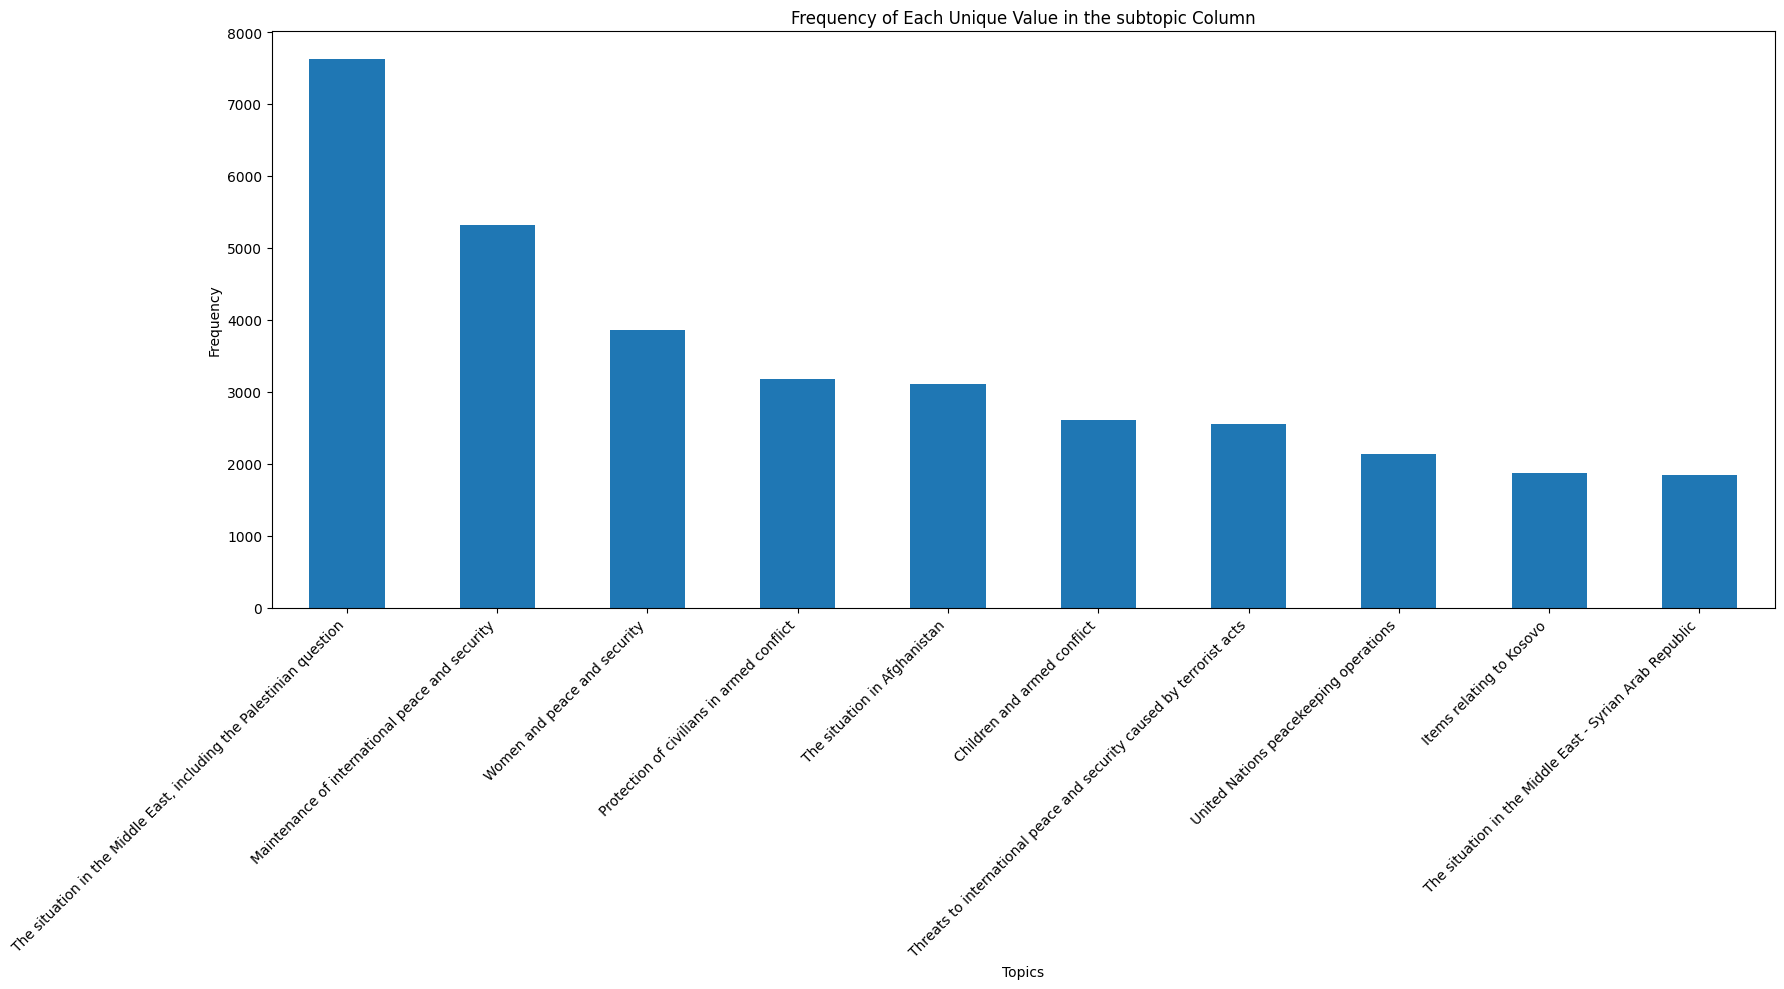

In [ ]:
# Frequency of each unique value in the UNSC "subtopic" column 

topic2_counts = df_UNSC_meta_speeches['subtopic'].value_counts().head(10)
plt.figure(figsize=(18, 10))
topic2_counts.plot(kind='bar')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Frequency of Each Subtopic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Fine-Tune Models

Models: T5 or BERT


## Training with T5

In [ ]:
# Load pre-trained model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Load dataset (this should include CoT examples)
dataset = load_dataset('path_to_your_dataset')

# Preprocess the dataset
def preprocess_data(examples):
    inputs = examples['input']
    cot_steps = examples['cot']  # Chain of Thought steps
    outputs = examples['output']

    model_inputs = tokenizer(inputs + cot_steps, max_length=512, 
                             truncation=True, 
                             padding='max_length', return_tensors="pt")
    labels = tokenizer(outputs, max_length=128, 
                       truncation=True, 
                       padding='max_length', return_tensors="pt")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = dataset['train'].map(preprocess_data, batched=True)
val_dataset = dataset['validation'].map(preprocess_data, batched=True)

# Define training arguments
training_args = TrainingArguments(
    data_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=5e-5,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Fine-tune the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

## Training with BERT

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare your data
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

# Assuming 'speeches' is a pandas DataFrame with your text data
speeches['text'] = speeches['filename'].apply(lambda x: open(x).read())
dataset = speeches['text']
dataset = dataset.map(tokenize, batched=True, batch_size=len(dataset))

# Define the training arguments
training_args = TrainingArguments(
    data_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Create the Trainer and train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()

# Counterfactual Sampling

In [ ]:
class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self._number_of_visits = 0.
        self._results = 0.

    def expand(self):
        # Implement your expansion logic here
        pass

    def rollout(self):
        # Implement your rollout logic here
        pass

    def backpropagate(self, result):
        self._number_of_visits += 1.
        self._results += result
        if self.parent:
            self.parent.backpropagate(result)

    def is_fully_expanded(self):
        return len(self.children) > 0

    def best_child(self):
        # Implement your selection logic here
        pass

def MCTS(root, iterations):
    for _ in range(iterations):
        node = root
        while node.is_fully_expanded():
            node = node.best_child()
        if not node.is_terminal():
            node.expand()
        result = node.rollout()
        node.backpropagate(result)
    return root.best_child()
